**Introduction**

Video games makes up a major part of most people's entertainment time, attracting players of all ages and backgrounds. For researchers and developers, understanding how different players engage with games can inform better design decisions and improve marketing strategies. In this project, I will work with data collected from a Minecraft server managed by a UBC Computer Science research group led by Frank Wood. This server tracks player activity to support further research in topics such as player behavior. My focus is to explore whether player age and game experience can help predict who is likely to be a high contributor, someone who plays for one hour or more, so that recruitment efforts can be more effective and data quality can be maximized. 

Question: How does age and game experience predict whether a player will be a high contributor (i.e., someone who plays for one hour and more)?

High contributors typically generate more gameplay data, which is especially useful for analyzing in-game behavior and training models. By understanding which characteristics are linked to higher playtime, the research team can focus recruitment on players who are more likely to generate meaningful data, helping improve the efficiency and impact of the project.

Dataset description: 
The dataset contains two files: 
1. players.csv file: contain 196 players and 7 variables
+ experience: Experience level of the player (Categorical: Pro, Veteran, Regular, Amateur, Beginner)
+ subscribe: Whether the player subscribed to a newsletter (Logical: True or False)
+ hashedEmail: An unique identifier for each player, used to protect privacy (Categorical)
+ played_hours: Total number of hours a player played (Character)
+ name: Player's username (Character)
+ gender: Player's self-identified gender (Categorical: Male, Female, Non-binary, etc)
+ age: Age of the player in years (Numeric)

2. sessions.csv file: Recording of 1535 game sessions and 5 variables
+ hasedEmail: An unique identifier for each player, used to protect privacy (Categorical)
+ start_time / end_time: Start and end timestamps of game sessions
+ original_start_time / original_end_time: Unix timestamps

Potential issues: 
Several variables in the dataset, such as experience level, are self-reported, which introduces potential issues like inaccuracy, subjectivity, and sampling bias. Players may overestimate their experience, and categories like experience level are subjective with no set definitions. These factors can introduce reduce the predictive accuracy of models, especially when trying to identify high contributors. Careful data cleaning and grouping of sparse categories may help mitigate these limitations.

To answer the question, I will use the players dataset because it contains all the necessary information such as the player characteristics. 

player csv link https://raw.githubusercontent.com/ashleyan1207/DSCI-100-Project/refs/heads/main/players.csv

sessions csv link https://raw.githubusercontent.com/ashleyan1207/DSCI-100-Project/refs/heads/main/sessions.csv

**Methods and Results**

*Loading Data and Wrangling / Cleaning Data*

For this analysis, players are categorized into two contribution levels based on total playtime: High contributors (≥1 hours), who provided most of gameplay data, and low contributors (<1 hour), who contributed less. the one hour threshold was chosen because longer playtime is more likely to produce sufficient data for analysis and model traning. This threshold is further supported by the distribution of playtime, which shows that most players either play for below an hour or well over one hour, making it a natural dividing point for classification. Simplifying the outcome variable into two categories support the use of straightforward classification models, improving interpretability and reducing complexity during model development. 

To do this, I loaded the necessary libraries and cleaned the data. The experience variable is converted into a factor for further classification purposes. A new column, contributor_type, is created to categorize players based on total playtime, aligning with the research question. Finally, rows with missing values are removed to ensure clean and reliable data for analysis. 

In [24]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(themis)
library(cowplot)
options(repr.matrix.max.rows = 5)

players_url <- "https://raw.githubusercontent.com/ashleyan1207/DSCI-100-Project/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/ashleyan1207/DSCI-100-Project/refs/heads/main/sessions.csv"

players <- read_csv (players_url) 
sessions <- read_csv (sessions_url) 

players <- players |> 
            mutate(experience = factor (experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), 
            contributor_type = case_when(played_hours >= 1 ~ "High", 
                                         played_hours < 1 ~ "Low")) |> 
            mutate(contributor_type = factor (contributor_type)) |> 
            drop_na ()
cat("Figure 1: Mutated Dataset") 
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Figure 1: Mutated Dataset

experience,subscribe,hashedEmail,played_hours,name,gender,Age,contributor_type
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,High
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,High
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,Low
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,High


*Summarizing Dataset*

I summarized the dataset by calculating the average playtime, average age, and player count for each experience level. Then, I separately summarized the average age and count of players by contribution type to explore potential patterns in engagement. 

From the summarized dataset, we can deduce that Regular players have the highest average playtime (~18.7 hours), suggesting strong engagement, although majority of players seem to have an Amateur experience level, with the count of 63 (Fig 2). This suggests that self-reported experience doesn't always reflect actual game engagement. Moreover, there is a large imbalance between High (42 players) and Low contributors (152 players), indicating that when performing classification prediction, scaling of the data is needed. 

In [25]:
avg_experience <- players |> 
            group_by(experience) |> 
            summarize(average_played_hours = mean(played_hours, na.rm = TRUE), 
                      average_age = mean(Age), 
                      count = n())

contributors <- players |> 
            group_by(contributor_type) |> 
            summarize(count = n(), average_age = mean(Age)) 

cat("Figure 2: Summarized Player Dataset") 
avg_experience
cat("Figure 3: Summarized Contributor Information") 
contributors 

Figure 2: Summarized Player Dataset

experience,average_played_hours,average_age,count
<fct>,<dbl>,<dbl>,<int>
Beginner,1.2485714,21.65714,35
Amateur,6.0174603,20.25397,63
Regular,18.7257143,20.60000,35
Pro,2.7846154,16.92308,13
Veteran,0.6479167,20.95833,48


Figure 3: Summarized Contributor Information

contributor_type,count,average_age
<fct>,<int>,<dbl>
High,42,20.30952
Low,152,20.57895


*Visualizing Data*

I created two visualization to explore potential relationships between player characteristics and total playtime. The first plot, player_plot_experience, is a bar chart helping to visualize which experience group contributed the most playtime overall. The second plot, player_plot_age, is a scatter plot showing the relationship between player age and total hours played, highlighting variability across ages. 

Visualizing the data, we can see that both age and experience level seems to be able to predict a player's contribution level. The bar chart clearly indicates that "Regular" and "Amateur" players contribute the vast majority of hours, suggesting that experience levels are highly indicative of consistent engagement. Concurrently, the scatter plot shows that the highest total hours played are mostly among younger players, between 15 to 25 years old, with a notable decline in hours played as age increase beyong this range. To precisely identify whether these characteristics predict a "high contributor", we will perform the k-nearest neighbor classifications. K-NN is a suitable model for this task as it effectively classifies discrete categories, accommodates multiple predictors without making assumptions about data distribution. 

Figure 4: Visualization of Potential Factors in the Players Dataset

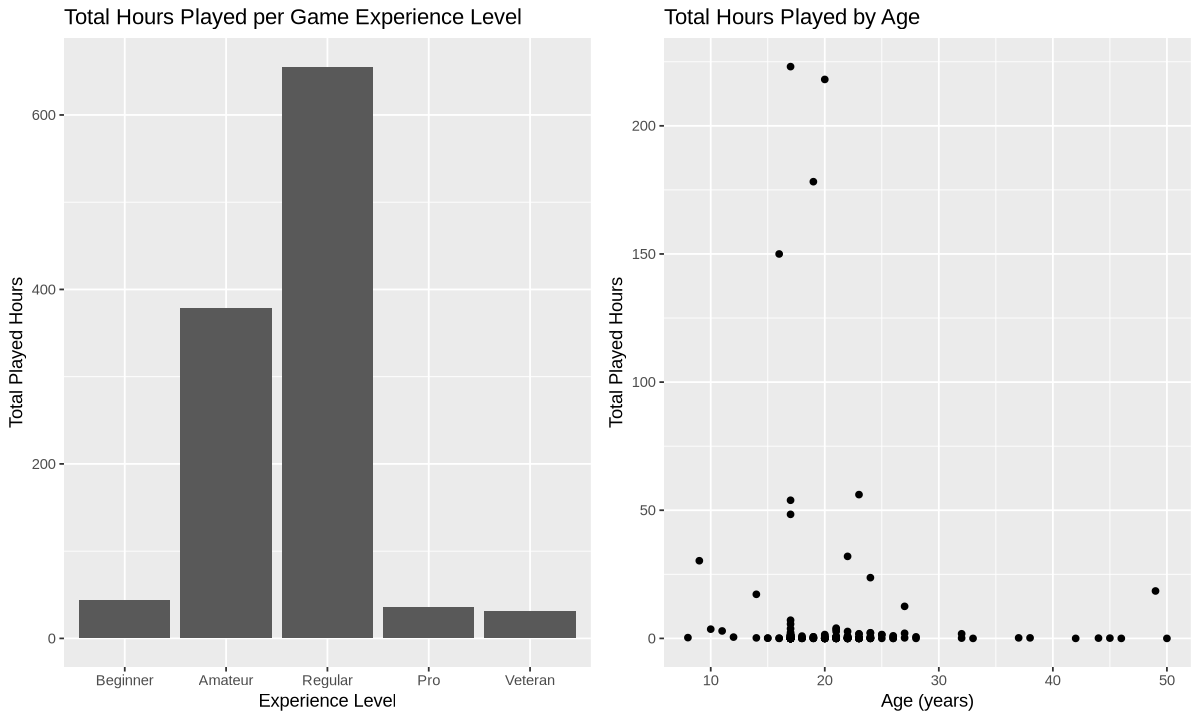

In [20]:
player_plot_experience <- ggplot (players, aes(x = experience, y = played_hours)) + 
                            geom_bar (stat = "identity") + 
                            labs (x = "Experience Level", y = "Total Played Hours", title = "Total Hours Played per Game Experience Level") 

player_plot_age <- ggplot(players, aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(x="Age (years)", y = "Total Played Hours", title = "Total Hours Played by Age")

options (repr.plot.width=10, repr.plot.height = 6) 
cat("Figure 4: Visualization of Potential Factors in the Players Dataset") 
plot_grid(player_plot_experience, player_plot_age, ncol = 2)

*Data Analysis*

To perform K-NN classification, the dataset is split into training (70% of the data) and testing set (30% of the data) using stratified sampling to maintain the proportion of contributor types. By doing this, we can have the data available to both train the model and evaluate its accuracy. The training data was preprocessed using a recipe that scaled, centered the predictors to ensure comparability by having a mean of 0 and a standard deviation of 1. Moreover, since Low contributors significantly outnumber High contributors, upsampling was applied to balance the class distribution and ensure both groups are equally represented during model training. 

A K-NN classifier was set up with the number of neighbors (K) as a tunable parameter. To identify the optimal K, 5-fold cross-validation was used on the training data, different values of K ranging from 1 to 10 are tested. 
The results were then plotted to visualize how accuracy changed with different K values, allowing for the selection of the best performing model with the highest accuracy. 

Figure 5: Visualization of different K value's accuracy

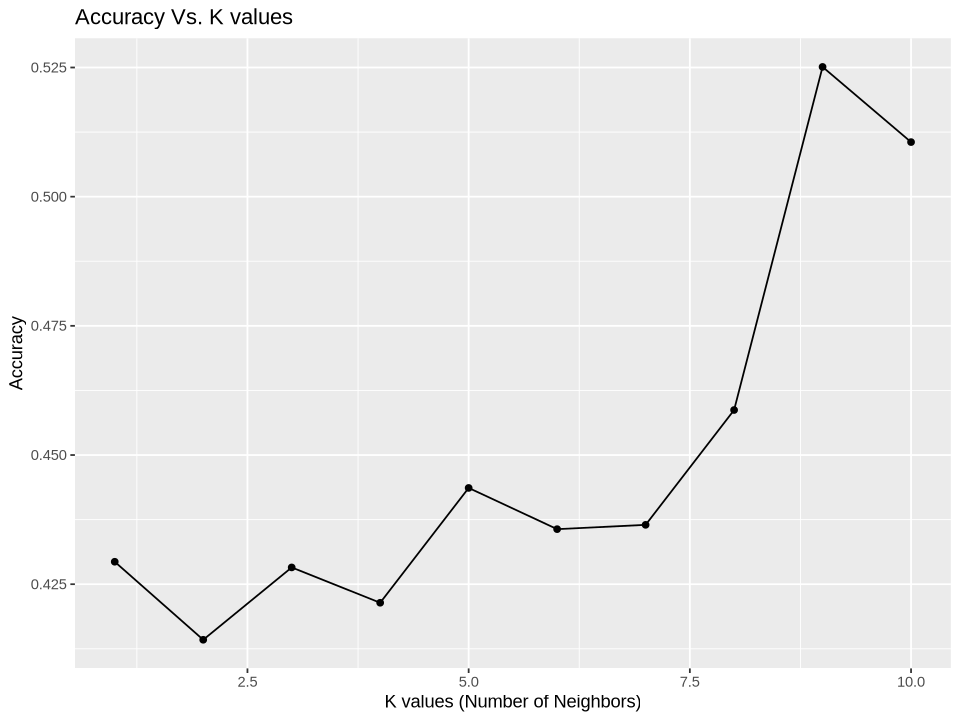

In [21]:
set.seed(2025)
selected_players <- players |>
    mutate(experience_label = as.numeric(experience))|>
    select(contributor_type, experience, experience_label, Age)

player_split <- initial_split (selected_players, prop = 0.7, strata = contributor_type) 
player_train <- training(player_split)
player_test <- testing(player_split)

player_recipe <- recipe (contributor_type ~ experience_label + Age, data = player_train) |> 
        step_scale(all_predictors ()) |>
        step_center(all_predictors ()) |>
        step_upsample(contributor_type, over_ratio = 1, skip = TRUE)

knn_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |> 
            set_engine("kknn") |> 
            set_mode("classification") 

player_vfold <- vfold_cv (player_train, v = 5, strata = contributor_type) 
k_vals <- tibble (neighbors = seq (from = 1, to = 10, by = 1))

knn_results <- workflow() |> 
            add_recipe (player_recipe) |> 
            add_model (knn_tune) |> 
            tune_grid (resample = player_vfold, grid = k_vals) |> 
            collect_metrics() |> 
            filter (.metric == "accuracy") 

cross_val_plot <- ggplot (knn_results, aes (x = neighbors, y = mean)) + 
                geom_point() + 
                geom_line () + 
                labs (x = "K values (Number of Neighbors)", y = "Accuracy", title = "Accuracy Vs. K values") 

options(repr.plot.width = 8, repr.plot.height = 6) 
cat("Figure 5: Visualization of different K value's accuracy") 
cross_val_plot

In [22]:
best_k <- knn_results |> 
        arrange(desc(mean)) |> 
        slice (1) |> 
        pull(neighbors)
best_k

[1] 9

*Predicting classifications*

Through analyzing figure 5 and the result from best_k above, it was found that k = 9 resulted the highest accuracy compared to other values. Hence, 9 is the optimal k value to use for our model. 

With this value, I created a K-nearest neighbors classifier that predicts classification based on the 9 nearest neighbors. After fitting the model to all training data, I used the model to predict contributor types for the test set, which allowed me to evaluate the model's performance using accuracy metrics and confusion matrix. 

In [27]:
player_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 9) |> 
            set_engine ("kknn") |> 
            set_mode ("classification") 

player_fit <- workflow() |> 
        add_recipe (player_recipe) |> 
        add_model (player_spec) |> 
        fit (data = player_train) 

player_predictions <- predict (player_fit, player_test) |> 
        bind_cols (player_test) 

mnist_metrics <- player_predictions |> 
        metrics(truth = contributor_type, estimate = .pred_class) 

player_mat <- player_predictions |> 
        conf_mat(truth = contributor_type, estimate = .pred_class) 

cat("Figure 6: Classification model result accuracy metric") 
mnist_metrics
cat("Figure 7: Classification model result confusion matrix") 
player_mat

Figure 6: Classification model result accuracy metric

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4237288
kap,binary,-0.1635731


Figure 7: Classification model result confusion matrix

          Truth
Prediction High Low
      High    4  25
      Low     9  21